<a href="https://colab.research.google.com/github/phytometrics/plant_phenotyping_python/blob/main/notebooks/aravib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Aravib:シロイヌナズナの茎振動の定量
![picture 1](https://cdn.jsdelivr.net/gh/phytometrics/plant_phenotyping_python@main/assets/250c45a7812ab2a2e37cc49e4cda9c21935691be93e73d0723c5b4a4b8f6a746.png)  

Nakata et al., 2018より転載

 ## ライセンス

 - High-Throughput Analysis of Arabidopsis Stem Vibrations to Identify Mutants With Altered Mechanical Properties. 2018. Front. Plant Sci.
    - https://www.frontiersin.org/articles/10.3389/fpls.2018.00780/full
    - CC-BY

 - 公式レポジトリ
    - https://github.com/MTNakata/AraVib
    - MIT
- 本章プログラムコード
   - CC-BY-NC
## 解説
中田らの研究グループは、植の茎の物性を定量的な指標として細胞壁の変異体をスクリーニングするAraVibというPythonベースのソフトウェアを開発しました。茎の振動を高速フーリエ変換によって周波数解析し、その周波数スペクトルを用いて定量化します。本章では、AraVibの概要説明と再実装、さらには野生型を用いたパラメーター抽出を行います。

## 注意事項
再実装にあたって解説のため一部コードを簡略化したり、書き換えたり、また、使用ライブラリを変更していることがあります。そのため、論文の結果と厳密に一致しないことに留意してください。

## 環境構築・データセット準備

In [1]:
!pip install ffmpeg-python

In [15]:
import os
import cv2
import tempfile
import ffmpeg
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import Video
from tqdm import tqdm
from collections import deque
from scipy.fft import fft
from scipy.signal import hann
from skimage.util import montage
from google.colab.patches import cv2_imshow


In [2]:
# frontiers in plant science 公式リンク
!wget -O data.zip https://ndownloader.figstatic.com/collections/4130561/versions/1
!unzip data.zip -d data
# !git clone https://github.com/MTNakata/AraVib

--2024-01-04 00:42:59--  https://ndownloader.figstatic.com/collections/4130561/versions/1
Resolving ndownloader.figstatic.com (ndownloader.figstatic.com)... 34.246.107.109, 34.246.25.17, 2a05:d018:1f4:d003:49db:9d1b:58fe:61eb, ...
Connecting to ndownloader.figstatic.com (ndownloader.figstatic.com)|34.246.107.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20799764 (20M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  19.84M  13.5MB/s    in 1.5s    

2024-01-04 00:43:01 (13.5 MB/s) - ‘data.zip’ saved [20799764/20799764]

Archive:  data.zip
 extracting: data/Presentation_1_High-Throughput Analysis of Arabidopsis Stem Vibrations to Identify Mutants With Altered Mechanical Properties.PDF  
 extracting: data/Video_1_High-Throughput Analysis of Arabidopsis Stem Vibrations to Identify Mutants With Altered Mechanical Properties.MP4  
 extracting: data/Video_2_High-Throughput Analysis of Arabidopsis Stem Vibrations to Identi

In [11]:
folder_path = '/content/data'
files = sorted(os.listdir(folder_path))
files = [x for x in files if x.endswith(".MP4")]
for file in files:
    print(file[:10]+"..."+file[-5:])

Video_1_Hi...s.MP4
Video_2_Hi...s.MP4
Video_3_Hi...s.MP4
Video_4_Hi...s.MP4
Video_5_Hi...s.MP4
Video_6_Hi...s.MP4
Video_7_Hi...s.MP4
Video_8_Hi...s.MP4


From supple information of Front. in Plant Sci.

Supplementary Movie 1. The high speed-shooting video (240 fps) of the damped free vibration of a Col-0 inflorescence stem.

Supplementary Movie 2. Slow-motion video (30-fps) of Supplementary Movie 1.

Supplementary Movie 3. Slow-motion video (30-fps) of binarized images of Supplementary Movie 1.

Supplementary Movie 4. Supplementary Movie 2 with a red circle indicating the detected centroid coordinate.

Supplementary Movie 5. The high speed-shooting video (240 fps) of the damped free vibration of a nst1 nst3 inflorescence stem.

Supplementary Movie 6. Slow-motion video (30-fps) of Supplementary Movie 5.

Supplementary Movie 7. The high speed-shooting video (240 fps) of the damped free vibration of a wrky12 inflorescence stem.

Supplementary Movie 8. Slow-motion video (30-fps) of Supplementary Movie 7.

In [12]:
folder_path = '/content/data'
files = os.listdir(folder_path)
for i, file_name in enumerate(files):
    new_file_name = f'video{i+1}.mp4'
    old_file_path = os.path.join(folder_path, file_name)
    new_file_path = os.path.join(folder_path, new_file_name)
    os.rename(old_file_path, new_file_path)  # Rename the file

## Step by Step 実装

In [16]:
path = "/content/data/video1.mp4"
Video.from_file(path, width=256, height=256)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x009\x900mdat\x00\x00\…

In [17]:
# 動画からフレーム画像の読み込み
video = cv2.VideoCapture(path)

# Iterate through each frame and obtain images as list
frames = []
while video.isOpened():
    # Read the next frame
    ret, frame = video.read()
    if ret == False:
        break
    frames.append(frame)
video.release()
frames = np.array(frames)
print(frames.shape)

# video1.mp4をnumpy imagesに変換し、720枚、高さ600px,幅720pxのnumpy arrayとして扱います。

(720, 600, 720, 3)


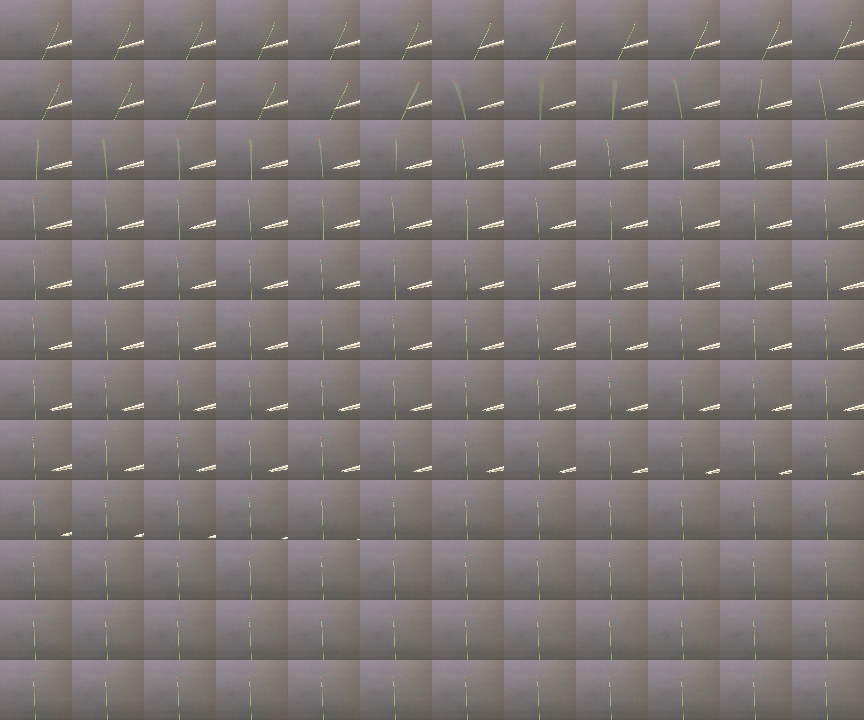

In [24]:


_frames = montage(frames[::5], channel_axis=-1)
_frames = cv2.resize(_frames, dsize=None, fx=0.1, fy=0.1)
cv2_imshow(_frames)

In [ ]:
def red_region_detection(frames, h=[5,165], s=60, v=90):
    # Define lower and upper bounds for HSV values for the lower red range
    lower_bound1 = np.array([0, s, v])
    upper_bound1 = np.array([h[0], 255, 255])
    # Define lower and upper bounds for HSV values for the upper red range
    lower_bound2 = np.array([h[1], s,v])
    upper_bound2 = np.array([180, 255, 255])
    # Kernel for noise removal
    kernel1 = np.ones((2,2),np.uint8)
    kernel2 = np.ones((15,15),np.uint8)

    red_bws = []  # red object as bright pixel binary

    for frame in frames:
        # red region detection
        img_hsv = cv2.cvtColor(frame[0:600,...], cv2.COLOR_BGR2HSV)
        blur = cv2.blur(img_hsv,(3,3))
        binary_mask1 = cv2.inRange(blur, lower_bound1, upper_bound1)
        binary_mask2 = cv2.inRange(blur, lower_bound2, upper_bound2)
        binary_mask = cv2.bitwise_or(binary_mask1, binary_mask2)
        # noise removal
        erosion = cv2.erode(binary_mask.astype(np.uint8)*255, kernel1, iterations=1)
        bw = cv2.dilate(erosion,kernel2,iterations=1)
        red_bws.append(bw)
    return np.array(red_bws)

def convert_to_coords(frames):
    coords = []
    for frame in frames:
        contours, _ = cv2.findContours(frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # if a single contour is detected, obtain the moment coordinate
        if len(contours) == 1:
            cnt = contours[0]
            M = cv2.moments(cnt)
            coord = [int(M['m10']/M['m00']),int(M['m01']/M['m00'])]
        else:
            coord = [np.nan, np.nan]
        coords.append(coord)
    df_coords = pd.DataFrame(coords, columns=['x', 'y'])
    return df_coords


red_bws = red_region_detection(frames)
df = convert_to_coords(red_bws)
df = df.interpolate()  # 検出不良フレームの線形補完
df

,x,y
0,593.0,214.0
1,593.0,214.0
2,593.0,213.0
3,593.0,213.0
4,593.0,213.0
...,...,...
715,325.0,179.0
716,326.0,179.0
717,327.0,178.0
718,327.0,178.0


検出座標を可視化してみましょう

In [ ]:
with tempfile.TemporaryDirectory() as temp_dir:
    my_deques = deque(maxlen=500)
    for i, frame in tqdm(enumerate(frames)):
        _frame = frame.copy()

        # 過去のフレームの位置を半透明で描画
        for j, coord in enumerate(list(my_deques)):
            x2, y2 = coord
            if not pd.isna(x2) and not pd.isna(y2):
                x2 = int(x2)
                y2 = int(y2)
                alpha = np.max([0, 1 - 0.1*(j+1)])
                if alpha > 0:
                    overlay = _frame.copy()
                    overlay = cv2.circle(overlay, (x2, y2), 8, (255, 0, 0), thickness=-1)
                    _frame = cv2.addWeighted(overlay, alpha, _frame, 1-alpha, 0)

        # 現在のフレームの位置を描画
        x1, y1 = df.loc[i]
        if not pd.isna(x1) and not pd.isna(y1):
            x1 = int(x1)
            y1 = int(y1)
            _frame = cv2.circle(_frame, (x1, y1), 10, (0, 0, 255), thickness=-1)
        my_deques.appendleft([x1,y1])

        frame_filename = f"{temp_dir}/frame_{i:04d}.png"
        _frame = cv2.resize(_frame, dsize=None, fx=0.25, fy=0.25)
        cv2.imwrite(frame_filename, _frame)
    try:
        (
            ffmpeg
            .input(f"{temp_dir}/frame_%04d.png", framerate=30)
            .output('/content/animation.mp4')
            .run(capture_stdout=True, capture_stderr=True)
        )
    except ffmpeg.Error as e:
        print(e.stdout.decode("utf8"))
        print(e.stderr.decode("utf8"))

Video.from_file('/content/animation.mp4', width=256, height=256)

720it [00:08, 85.78it/s]



ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --ena

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x01<\xe6mdat\x00\x…

In [ ]:
def displacement_to_neutral(df):
    df['norm'] = np.sqrt(df['x']**2 + df['y']**2)
    median_norm = df['norm'].median()
    df['displacement'] = median_norm - df['norm']
    df.drop('norm', axis=1, inplace=True)
    return df

def delta_movement(df):
    df['displacement_copy'] = df['displacement']
    df['rolled'] = np.roll(df['displacement_copy'], -1)
    df['dif'] = df['displacement_copy'] - df['rolled']
    df = df[:-1]
    df = df.drop(['displacement_copy', 'rolled'], axis=1)
    return df

def hanning_preprocess(df):
    hanning_window = hann(len(df))
    df["hanning"] = df["dif"].values * hanning_window
    return df

def fourier_transform(df):
    T = 1.0 / 240.0
    xf = np.linspace(0.0, 1.0/(2.0*T), len(df)//2)
    yf = fft(df["hanning"].values)
    spectrum = 2.0/len(df) * np.abs(yf[:len(df)//2])
    return xf, spectrum


aravib_df = displacement_to_neutral(df.copy())
aravib_df = delta_movement(aravib_df)
aravib_df = hanning_preprocess(aravib_df)
xf, spectrum = fourier_transform(aravib_df)
# Find the frequency corresponding to the maximum value in the windowed amplitude spectrum
max_amplitude = np.max(spectrum)
max_frequency = xf[np.argmax(spectrum)]

<ipython-input-57-1062eb52e3cc>:20: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  hanning_window = hann(len(df))


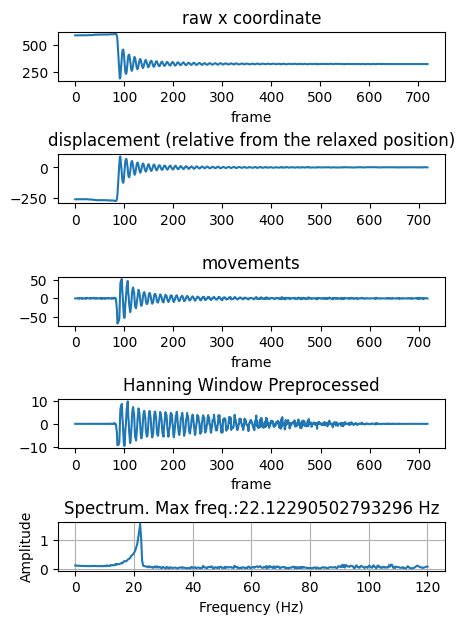

In [ ]:
plt.figure(figsize=(5,7))
plt.subplot(5,1,1)
plt.title("raw x coordinate")
plt.plot(df["x"])
plt.xlabel("frame")
plt.subplot(5,1,2)
plt.title("displacement (relative from the relaxed position)")
plt.plot(aravib_df["displacement"])

plt.subplot(5,1,3)
plt.title("movements")
plt.xlabel("frame")
plt.plot(aravib_df["dif"])

plt.subplot(5,1,4)
plt.title("Hanning Window Preprocessed")
plt.xlabel("frame")
plt.plot(aravib_df["hanning"])


plt.subplot(5,1,5)
plt.title('Spectrum. Max freq.:{} Hz'.format(max_frequency))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.plot(xf, spectrum)
plt.grid(True)

plt.subplots_adjust(hspace=1.5)